In [1]:
import pickle
import os

# Define the path for the model
MODEL_PATH = './model/best_model.pkl'

# Function to load the previous best model if it exists
def load_previous_model():
    if os.path.exists(MODEL_PATH):
        with open(MODEL_PATH, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {MODEL_PATH}")
        return model
    return None

def save_model(model):
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved in {MODEL_PATH}")

## Descripción de los datos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)
df = pd.read_excel('Absenteeism_at_work.xls')
df.rename(columns={'Work load Average/day ':'Work load Average/day'}, inplace=True)
df.head()

ID  Reason for absence  Month of absence  Day of the week  Seasons  \
0  11                  26                 7                3        1   
1  36                   0                 7                3        1   
2   3                  23                 7                4        1   
3   7                   7                 7                5        1   
4  11                  23                 7                5        1   

   Transportation expense  Distance from Residence to Work  Service time  Age  \
0                     289                               36            13   33   
1                     118                               13            18   50   
2                     179                               51            18   38   
3                     279                                5            14   39   
4                     289                               36            13   33   

   Work load Average/day  Hit target  Disciplinary failure  Education  Son  \
0                 239554          97                     0          1    2   
1                 239554          97                     1          1    1   
2                 239554          97                     0          1    0   
3                 239554          97                     0          1    2   
4                 239554          97                     0          1    2   

   Social drinker  Social smoker  Pet  Weight  Height  Body mass index  \
0               1              0    1      90     172               30   
1               1              0    0      98     178               31   
2               1              0    0      89     170               31   
3               1              1    0      68     168               24   
4               1              0    1      90     172               30   

   Absenteeism time in hours  
0                          4  
1                          0  
2                          2  
3                          4  
4                          2

In [3]:
"""
no falto                0
menos de un dia         <8
menos de una semana     <40
mas de una semana       >40
"""

df["clasificacion_abstinencia"] = df["Absenteeism time in hours"].apply(
    lambda x: 0 if x == 0 else 1 if x < 8 else 2 if x < 40 else 3
)
df = df.drop(
    columns=["ID", "Reason for absence", "Absenteeism time in hours"], errors="ignore"
)
df["clasificacion_abstinencia"].value_counts()

clasificacion_abstinencia
1    425
2    249
0     44
3     22
Name: count, dtype: int64

# Analisis

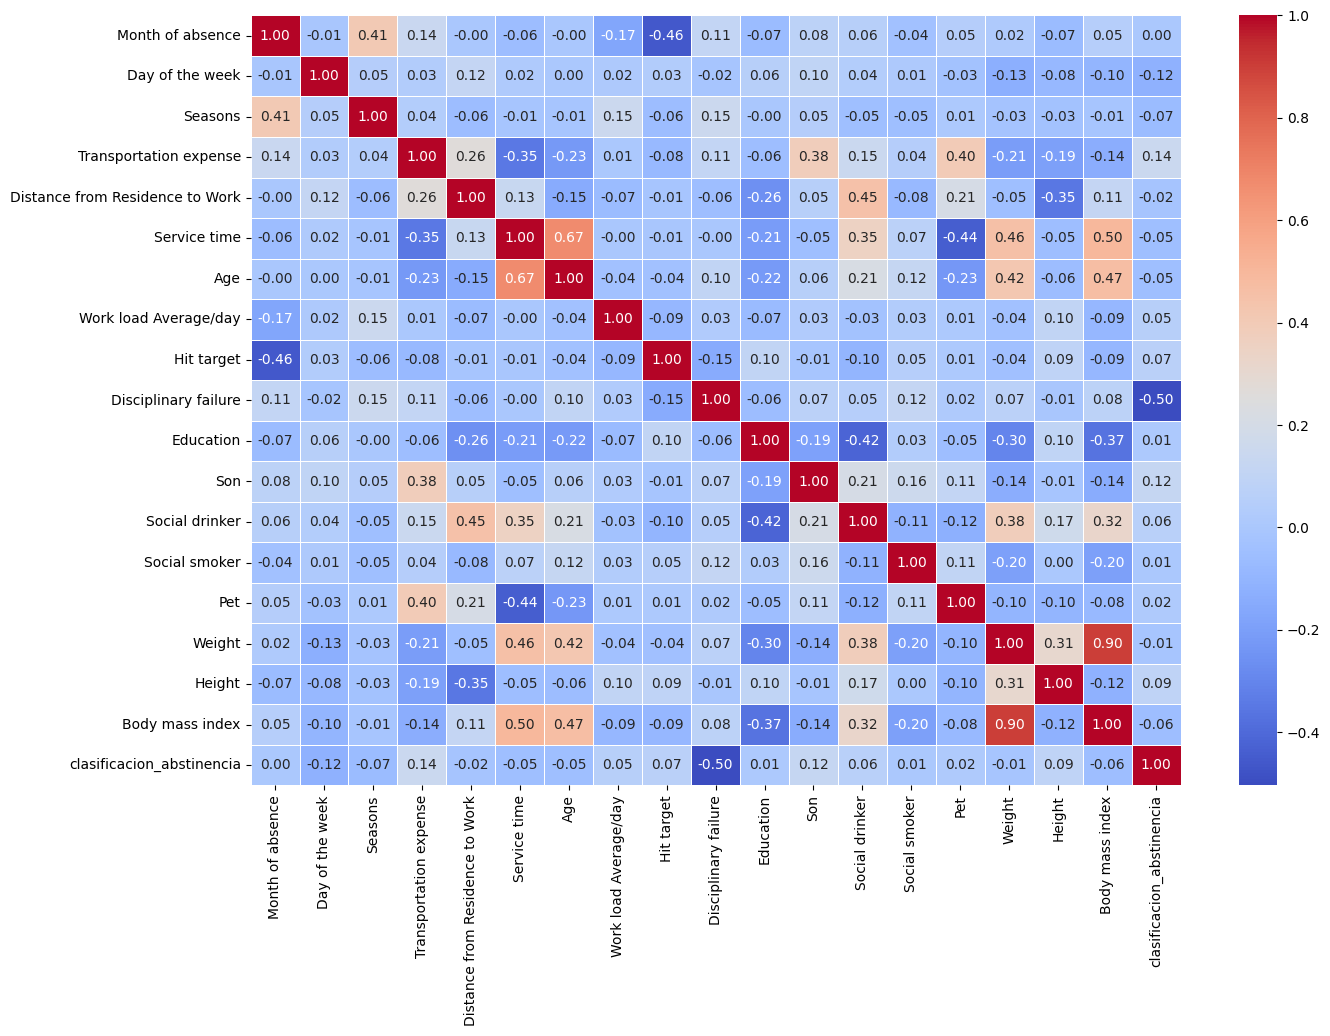

In [67]:
import seaborn as sns
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr(method="pearson")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5);

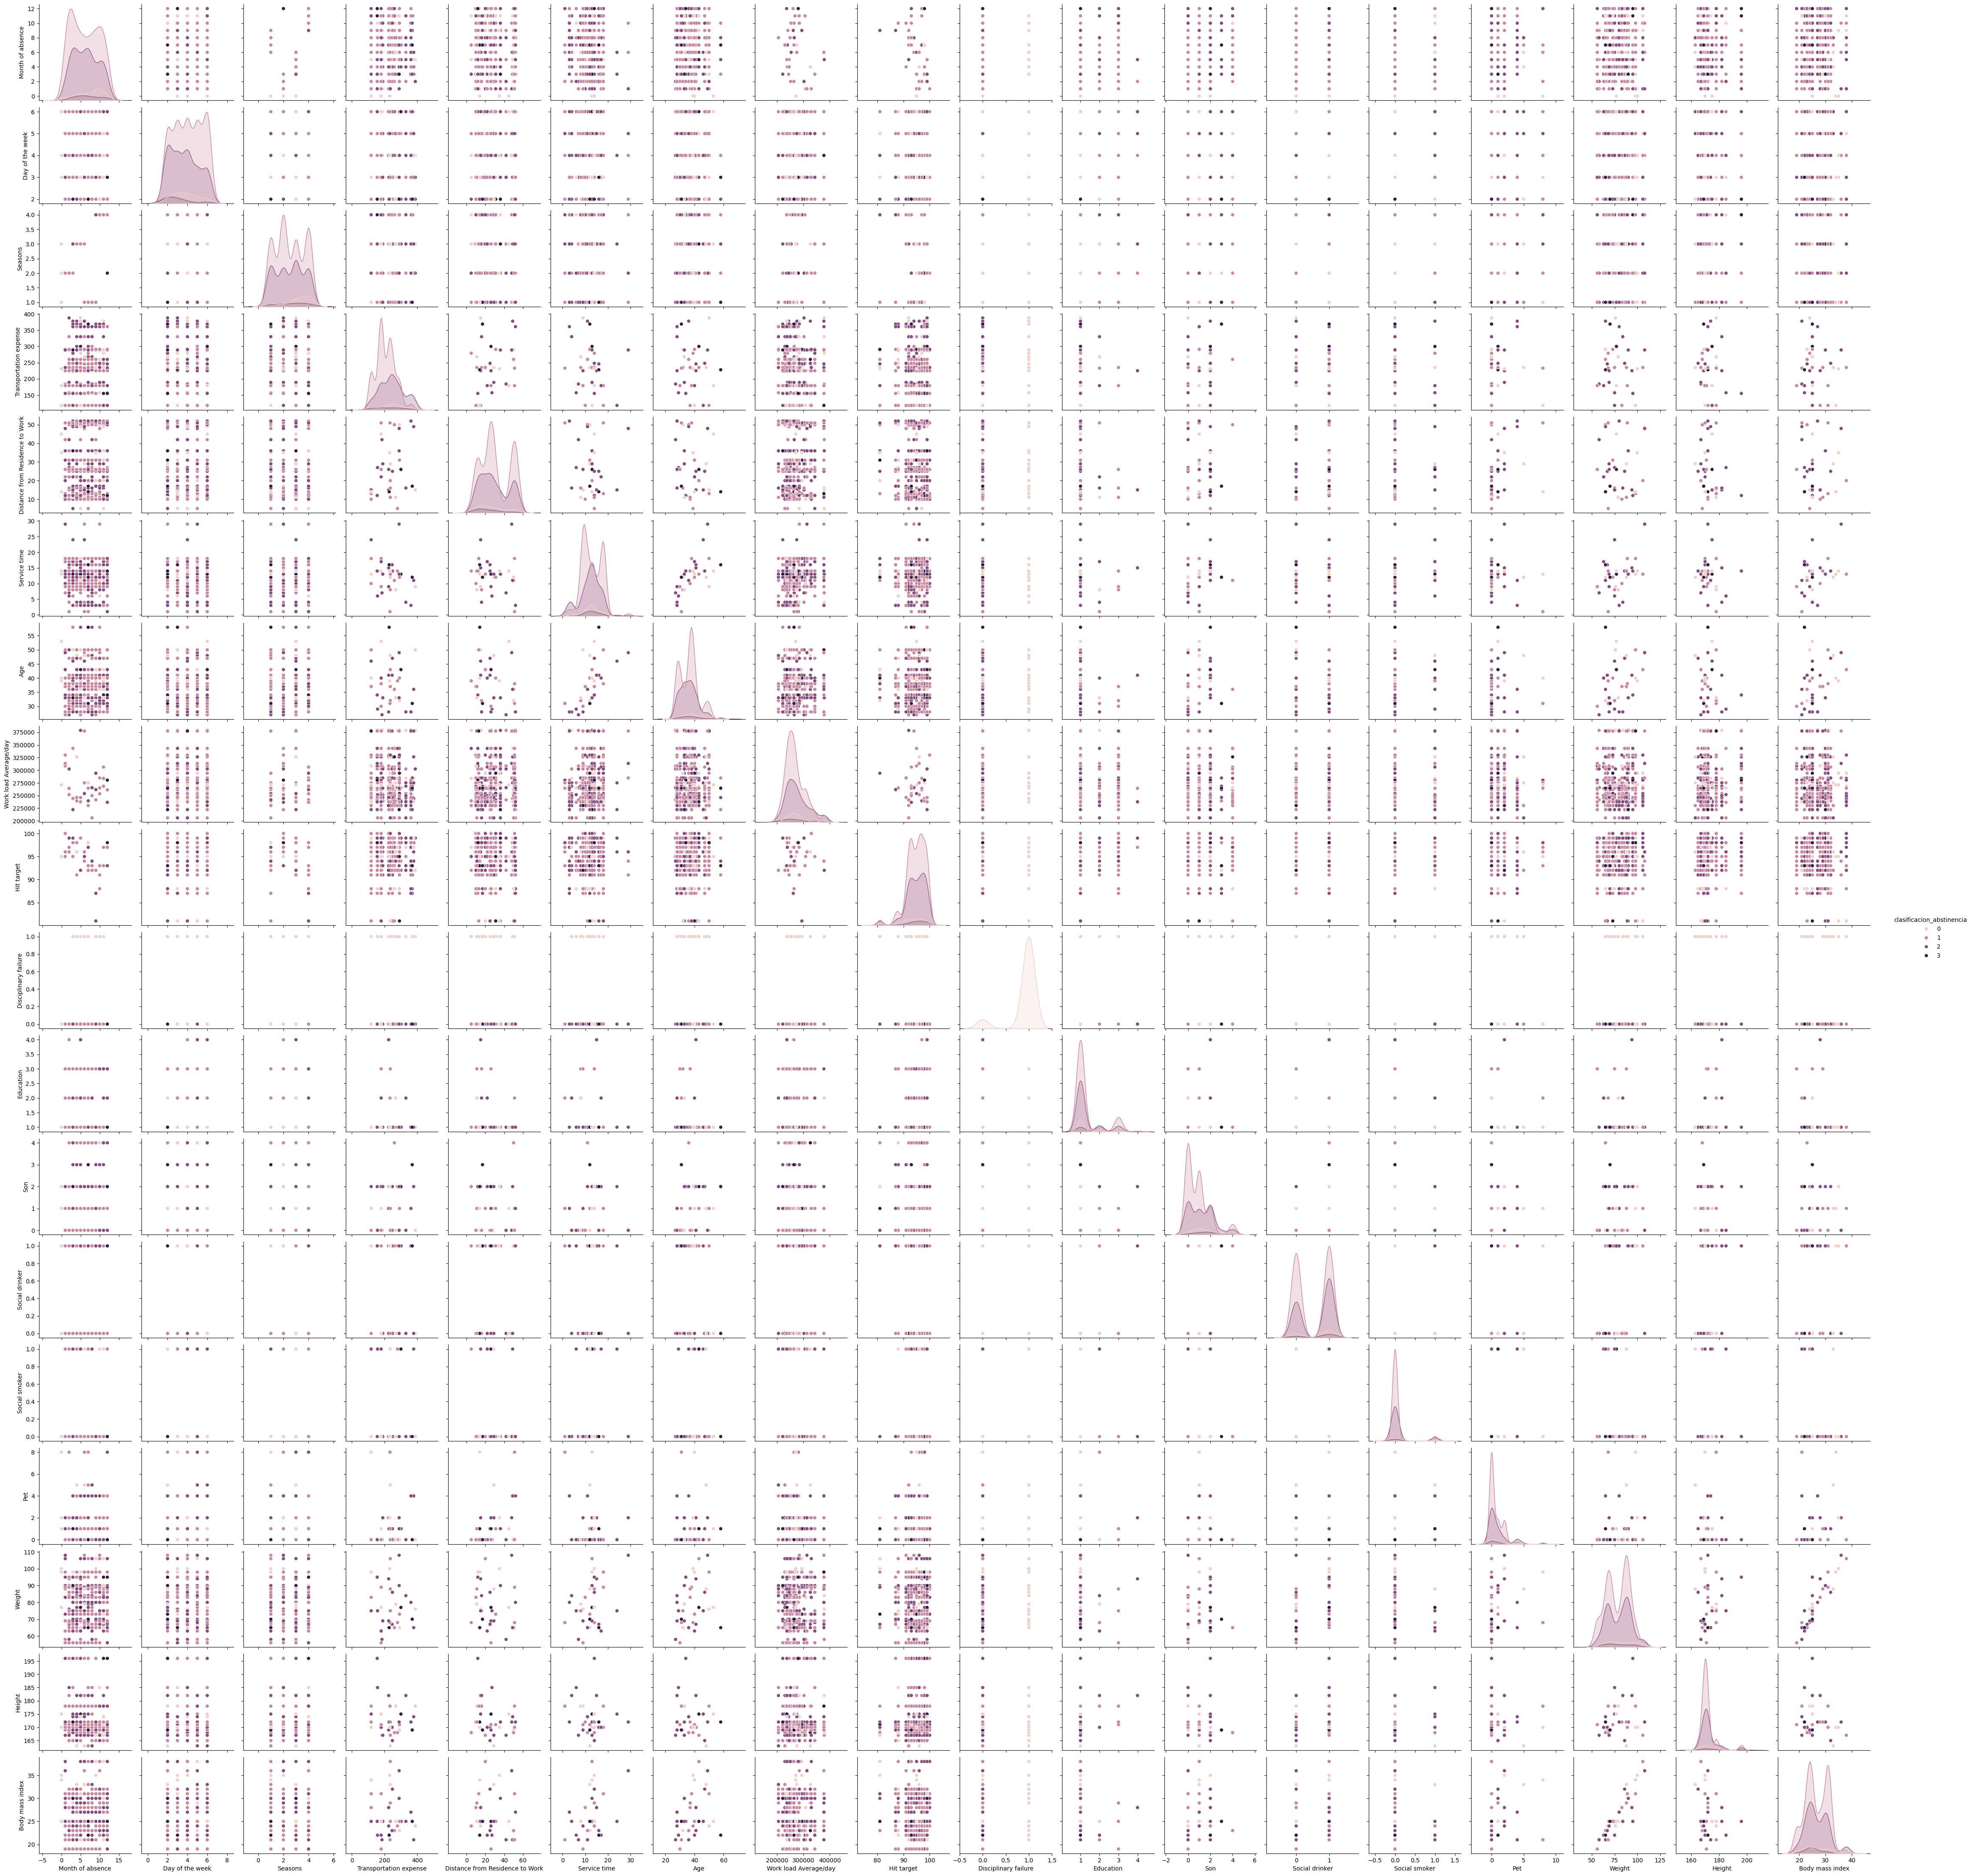

In [68]:
sns.pairplot(df, hue="clasificacion_abstinencia");

### **Diferentes profundidades del árbol**

In [55]:
from sklearn.model_selection import KFold
from sklearn import tree

cv = KFold(n_splits=20) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(df))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
  # X = df.drop(columns=["clasificacion_abstinencia"])
  # y = df["clasificacion_abstinencia"]

  fold_accuracy = []
  tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')
  
  for train_fold, valid_fold in cv.split(df):
    f_train = df.loc[train_fold]
    f_valid = df.loc[valid_fold]

    model = tree_model.fit(X = f_train.drop(columns=["clasificacion_abstinencia"]),
                           y = f_train["clasificacion_abstinencia"])
    valid_acc = model.score(X = f_valid.drop(columns=["clasificacion_abstinencia"]),
                            y = f_valid["clasificacion_abstinencia"])
    fold_accuracy.append(valid_acc)
  
  avg = sum(fold_accuracy)/len(fold_accuracy)
  accuracies.append(avg)

# Mostramos los resultados obtenidos
dataframe = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
dataframe = dataframe[["Max Depth", "Average Accuracy"]]
print(dataframe.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.509459
         2          0.206757
         3          0.410811
         4          0.475676
         5          0.482432
         6          0.497297
         7          0.532432
         8          0.556757
         9          0.591892
        10          0.602703
        11          0.602703
        12          0.600000
        13          0.597297
        14          0.597297
        15          0.598649
        16          0.597297
        17          0.602703
        18          0.598649
        19          0.601351


# DT Entrenamiento

In [19]:
from joblib import Memory

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.tree import DecisionTreeClassifier

# Cache
memory = Memory(location="./pipeline_cache", verbose=0)

pipeline = Pipeline(
    steps=[
        ("feature_selection", SelectKBest(score_func=f_classif)),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ],
    memory=memory
)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = df.drop(columns=["clasificacion_abstinencia"])
y = df["clasificacion_abstinencia"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
param_grid = {
"feature_selection__k": range(1, 10),
"feature_selection__score_func": [f_classif, chi2],
"classifier__criterion": ["gini", "entropy"],
"classifier__max_depth": range(1, 10),
"classifier__min_samples_split": range(2, 10),
"classifier__min_samples_leaf": range(1, 10),
"classifier__class_weight": ["balanced", None]
}

current_model = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=10, scoring="balanced_accuracy")

current_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(memory=Memory(location=./pipeline_cache\joblib),
                                steps=[('feature_selection', SelectKBest()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': range(1, 10),
                         'classifier__min_samples_leaf': range(1, 10),
                         'classifier__min_samples_split': range(2, 10),
                         'feature_selection__k': range(1, 10),
                         'feature_selection__score_func': [<function f_classif at 0x000002825EC13C40>,
                                                           <function chi2 at 0x000002825EC13E20>]},
             scoring='balanced_accuracy')

In [4]:
current_model = load_previous_model() or current_model

Model loaded from ./model/best_model.pkl


In [5]:
current_model.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 8,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'feature_selection__k': 4,
 'feature_selection__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

In [6]:
best_selector = current_model.best_estimator_.named_steps["feature_selection"]
best_classifier = current_model.best_estimator_.named_steps["classifier"]

In [13]:
for feature, score in zip(
    X.columns[best_selector.get_support()],
    best_selector.scores_[best_selector.get_support()],
):
    print(f"{feature}: {score:.2f}")

Day of the week: 7.23
Transportation expense: 13.80
Disciplinary failure: 3042.80
Son: 8.85


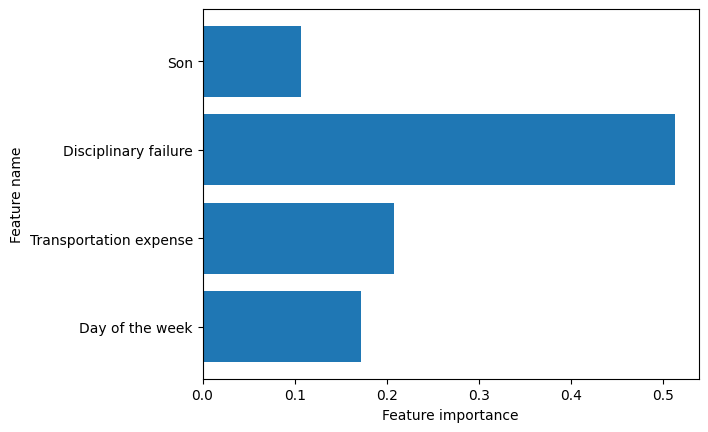

In [14]:
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

feature_names = X.columns[best_selector.get_support()]
plot_feature_importances(best_classifier, feature_names)

## Plot tree

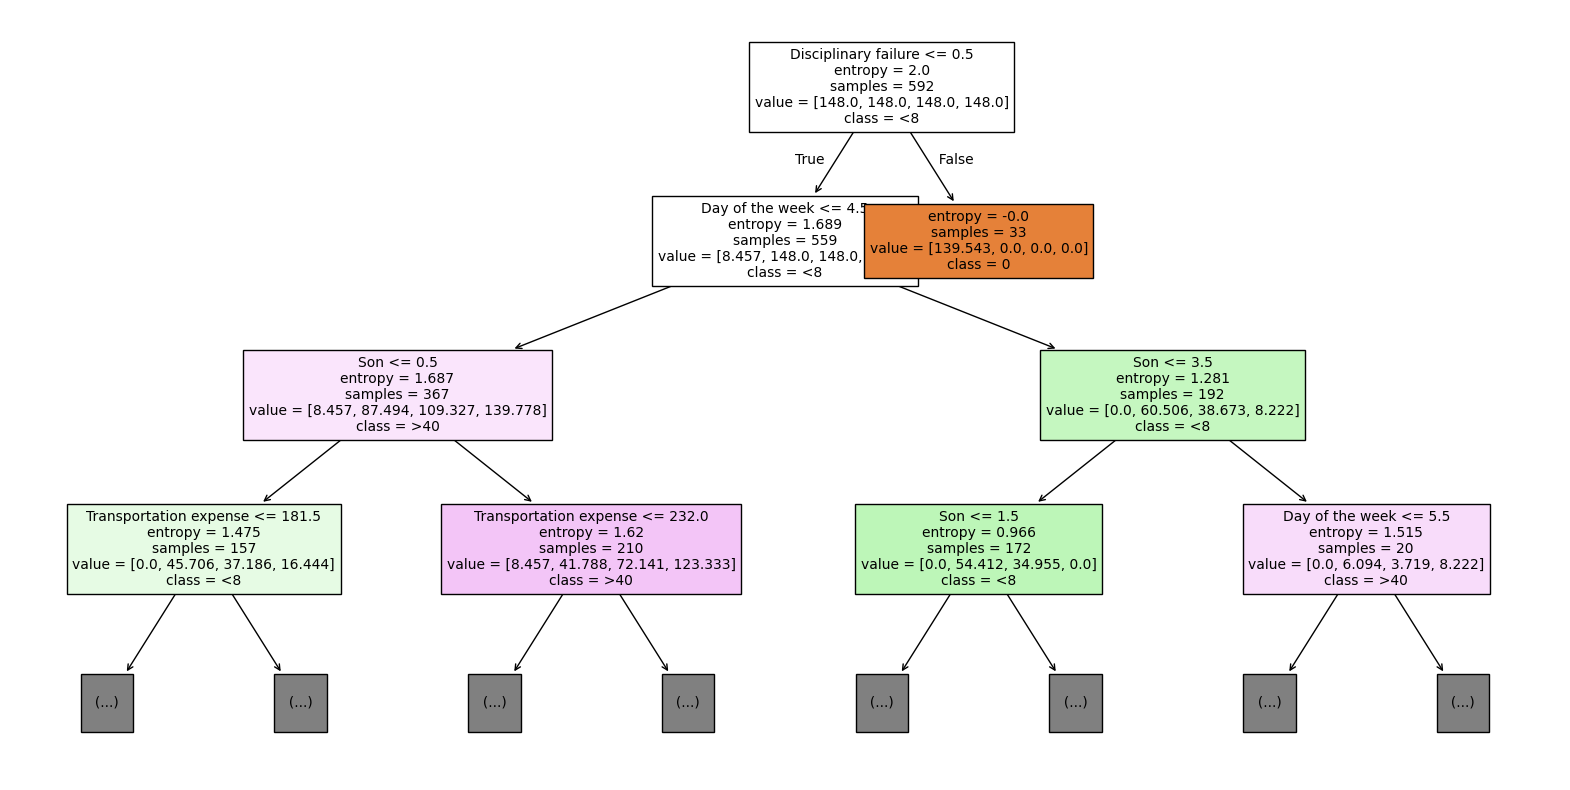

In [15]:
from sklearn import tree
plt.figure(figsize=(20, 10))
tree.plot_tree(best_classifier, feature_names=feature_names, filled=True, fontsize=10, max_depth=3, class_names=["0", "<8", "<40", ">40"]);

In [16]:
from supertree import SuperTree

super_tree = SuperTree(
    model=best_classifier,
    feature_data=X_train[feature_names],
    target_data=y.values,
    feature_names=feature_names.tolist(),  # Use list instead of Index
    target_names=["0", "1", "2", "3"],
)
super_tree.show_tree(start_depth=3)

## Score

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

print("Accuracy of Decision:")
print(f"Accuracy of Decision Tree classifier on test set {accuracy_score(y_test, current_model.predict(X_test)):.2f}")
print(f"Accuracy of Decision Tree classifier on training set {accuracy_score(y_train, current_model.predict(X_train)):.2f}")

print("\nBalanced accuracy:")
print(f"Balanced accuracy of Decision Tree classifier on test set {balanced_accuracy_score(y_test, current_model.predict(X_test)):.2f}")
print(f"Balanced accuracy of Decision Tree classifier on training set {balanced_accuracy_score(y_train, current_model.predict(X_train)):.2f}")

Accuracy of Decision:
Accuracy of Decision Tree classifier on test set 0.62
Accuracy of Decision Tree classifier on training set 0.67

Balanced accuracy:
Balanced accuracy of Decision Tree classifier on test set 0.62
Balanced accuracy of Decision Tree classifier on training set 0.80


In [76]:
# Calcule la métrica de exactitud, precisión, recall y F1-score tanto  para  el entrenamiento como para la validación.
from sklearn.metrics import classification_report
print("Classification report test:")
print(classification_report(y_test, current_model.predict(X_test), target_names=["0", "<8", "<40", ">40"]))
print("Classification report entrenamiento:")
print(classification_report(y_train, current_model.predict(X_train), target_names=["0", "<8", "<40", ">40"]))

Classification report test:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
          <8       0.75      0.64      0.69        85
         <40       0.71      0.58      0.64        50
         >40       0.08      0.50      0.14         4

    accuracy                           0.62       148
   macro avg       0.56      0.62      0.55       148
weighted avg       0.71      0.62      0.66       148

Classification report entrenamiento:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        35
          <8       0.85      0.65      0.74       340
         <40       0.69      0.62      0.65       199
         >40       0.15      0.94      0.26        18

    accuracy                           0.67       592
   macro avg       0.64      0.80      0.64       592
weighted avg       0.78      0.67      0.70       592



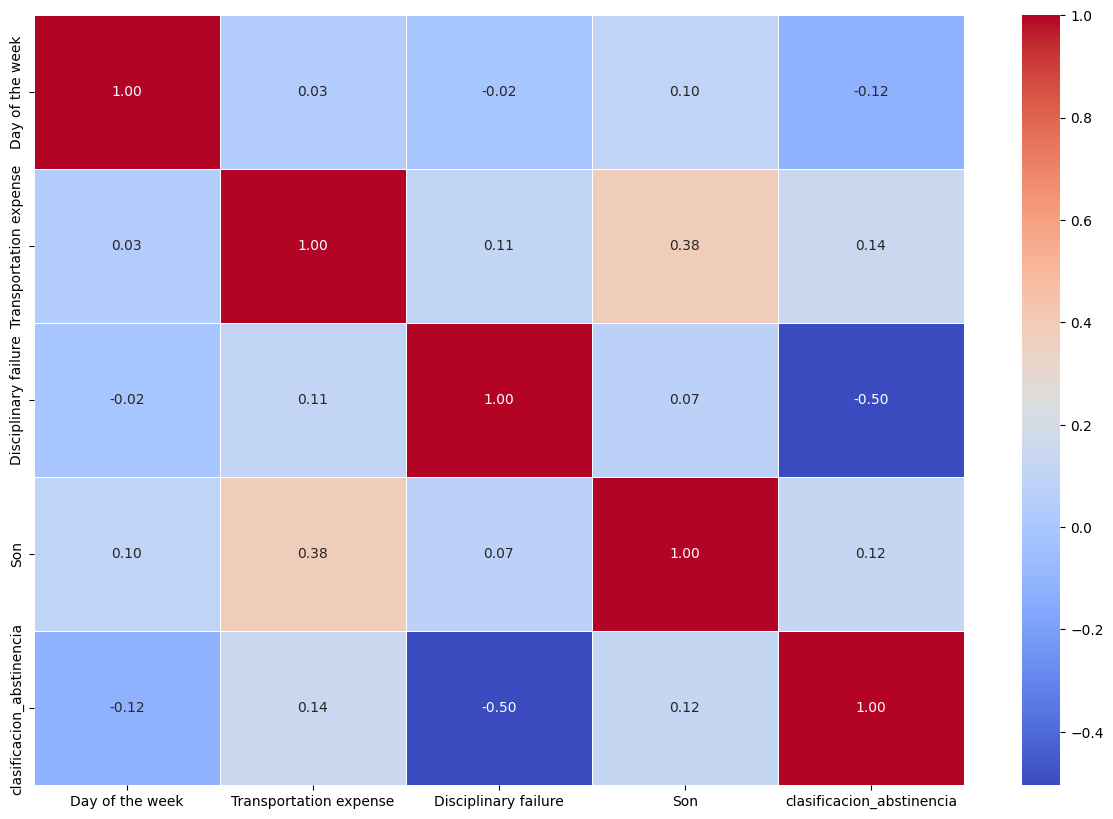

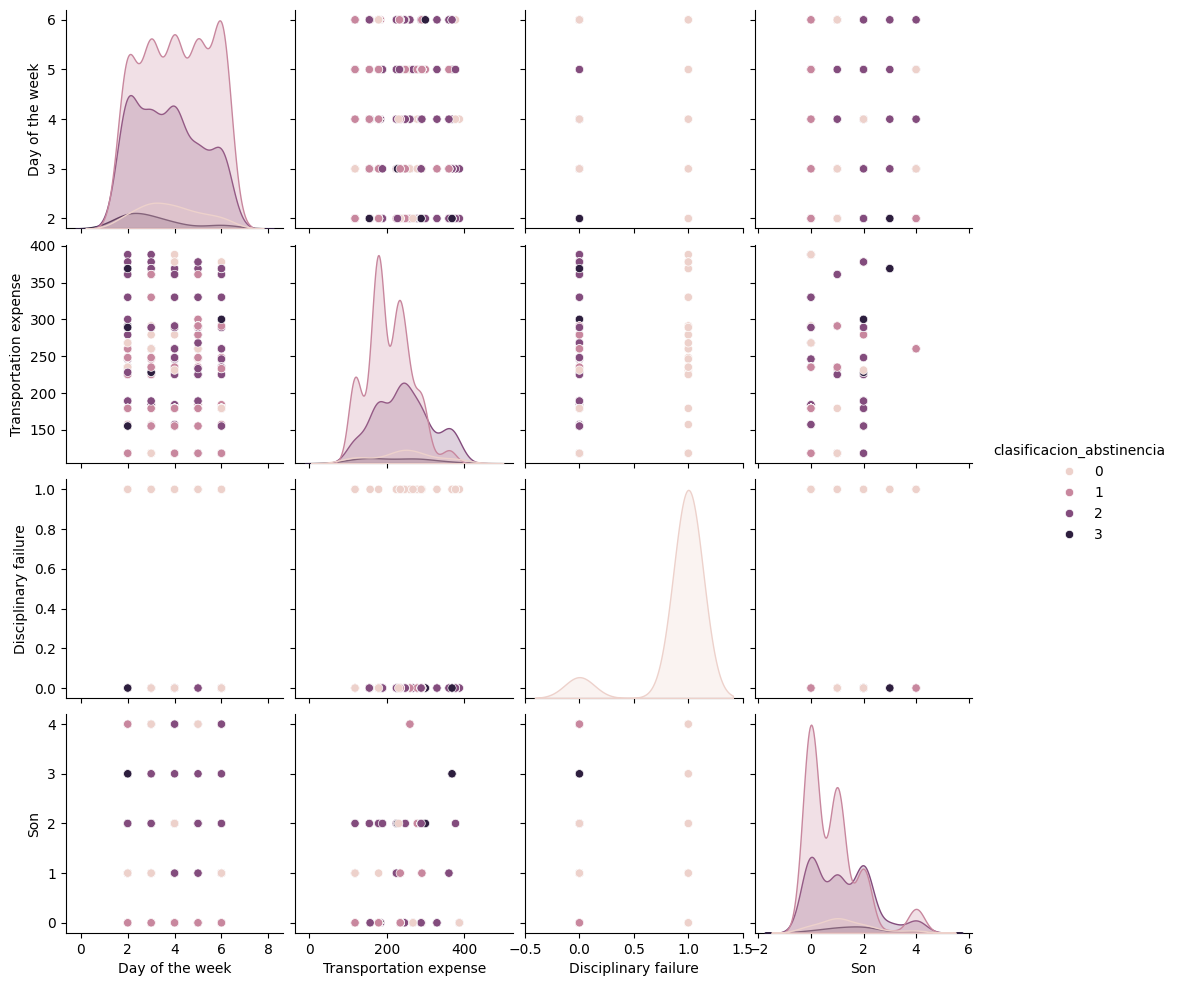

In [ ]:
import seaborn as sns
df_selected_features = pd.DataFrame(X[X.columns[best_selector.get_support()]])
df_selected_features["clasificacion_abstinencia"] = y
plt.figure(figsize=(15, 10))
correlation_matrix = df_selected_features.corr(method="pearson")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
sns.pairplot(df_selected_features, hue="clasificacion_abstinencia");

## matrix de confusion

Casos de test: 148
Casos de entrenamiento: 592


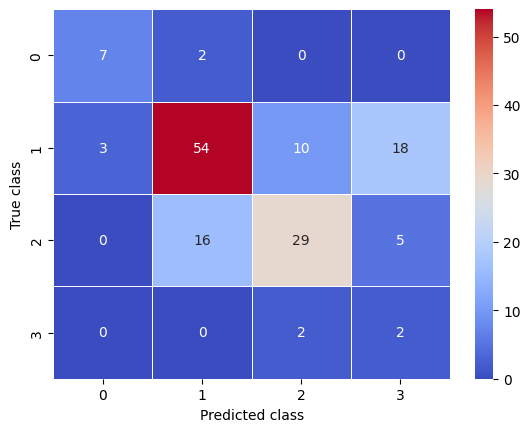

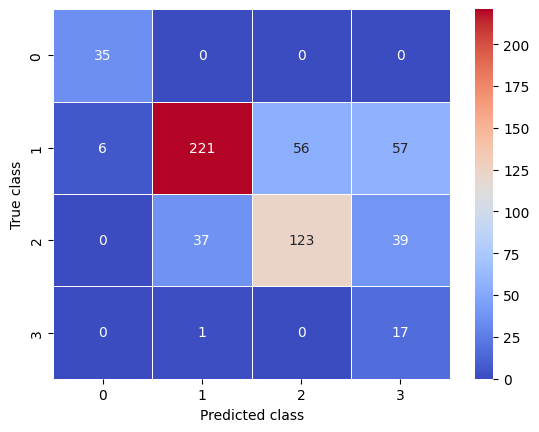

In [79]:
# matrix de confusion

from sklearn.metrics import confusion_matrix
import seaborn as sns

print(f"Casos de test: {y_test.size}")
conf_matrix = confusion_matrix(y_test, current_model.predict(X_test))
plt.figure()

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Predicted class")
plt.ylabel("True class")

print(f"Casos de entrenamiento: {y_train.size}")
conf_matrix = confusion_matrix(y_train, current_model.predict(X_train))
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.xlabel("Predicted class")
plt.ylabel("True class");

In [42]:
y_pred = current_model.predict(X_test)

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred
})

mask = (results_df['Real'] == 1) & (results_df['Predicho'] == 0)
cases = X_test[mask]
cases

Month of absence  Day of the week  Seasons  Transportation expense  \
306                10                3        4                     118   
403                 3                3        3                     118   
366                 1                2        2                     118   

     Distance from Residence to Work  Service time  Age  \
306                               13            18   50   
403                               13            18   50   
366                               13            18   50   

     Work load Average/day  Hit target  Disciplinary failure  Education  Son  \
306                 265017          88                     0          1    1   
403                 244387          98                     0          1    1   
366                 330061         100                     0          1    1   

     Social drinker  Social smoker  Pet  Weight  Height  Body mass index  
306               1              0    0      98     178               31  
403               1              0    0      98     178               31  
366               1              0    0      98     178               31

# Clasificacion bayesiana

In [128]:
# naive bayes classifier
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = GaussianNB()
model.fit(X_train, y_train)
model

GaussianNB()

## Scores

In [127]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

print("Accuracy of Naive Bayes:")
print(f"Accuracy of Naive Bayes classifier on test set {accuracy_score(y_test, model.predict(X_test)):.2f}")
print(f"Accuracy of Naive Bayes classifier on training set {accuracy_score(y_train, model.predict(X_train)):.2f}")

print("\nBalanced accuracy:")
print(f"Balanced accuracy of Naive Bayes classifier on test set {balanced_accuracy_score(y_test, model.predict(X_test)):.2f}")
print(f"Balanced accuracy of Naive Bayes classifier on training set {balanced_accuracy_score(y_train, model.predict(X_train)):.2f}")

Accuracy of Naive Bayes:
Accuracy of Naive Bayes classifier on test set 0.66
Accuracy of Naive Bayes classifier on training set 0.63

Balanced accuracy:
Balanced accuracy of Naive Bayes classifier on test set 0.47
Balanced accuracy of Naive Bayes classifier on training set 0.43


In [129]:
from sklearn.metrics import classification_report
print("Classification report test:")
print(classification_report(y_test, model.predict(X_test), target_names=["0", "<8", "<40", ">40"]))
print("Classification report entrenamiento:")
print(classification_report(y_train, model.predict(X_train), target_names=["0", "<8", "<40", ">40"]))

Classification report test:
              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
          <8       0.53      0.76      0.62        78
         <40       0.55      0.21      0.30        58
         >40       0.18      0.33      0.24         6

    accuracy                           0.50       148
   macro avg       0.38      0.37      0.34       148
weighted avg       0.51      0.50      0.46       148

Classification report entrenamiento:
              precision    recall  f1-score   support

           0       0.40      0.32      0.35        38
          <8       0.71      0.88      0.79       347
         <40       0.67      0.36      0.46       191
         >40       0.15      0.25      0.19        16

    accuracy                           0.66       592
   macro avg       0.48      0.45      0.45       592
weighted avg       0.66      0.66      0.64       592



Casos de test: 148
[  4 111  22  11]
Casos de entrenamiento: 592
[ 30 434 102  26]


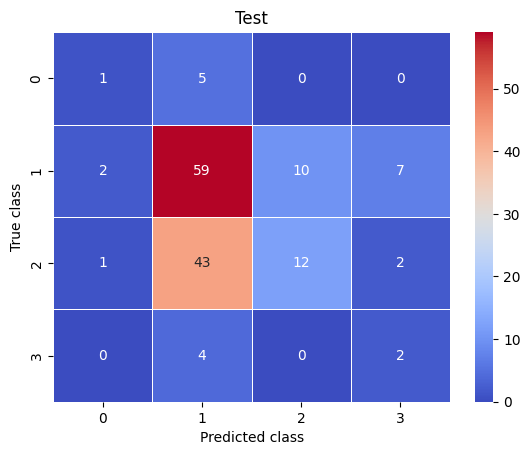

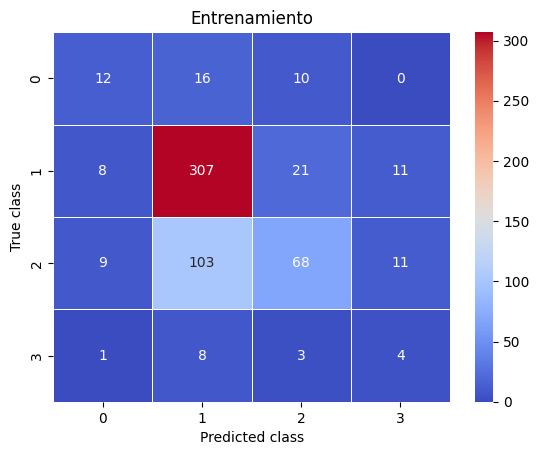

In [ ]:
print(f"Casos de test: {y_test.size}")
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
print(conf_matrix.sum(axis=0))
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.title("Test")
plt.xlabel("Predicted class")
plt.ylabel("True class")

print(f"Casos de entrenamiento: {y_train.size}")
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
print(conf_matrix.sum(axis=0))
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.title("Entrenamiento")
plt.xlabel("Predicted class")
plt.ylabel("True class");